In [10]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

LOAD AND INSPECT THE DATA

In [3]:
#load the species csv file
species_df = pd.read_csv('species_info.csv')
species_df.head()

,category,scientific_name,common_names,conservation_status
0,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,NaN
1,Mammal,Bos bison,"American Bison, Bison",NaN
2,Mammal,Bos taurus,"Aurochs, Aurochs, Domestic Cattle (Feral), Dom...",NaN
3,Mammal,Ovis aries,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",NaN
4,Mammal,Cervus elaphus,Wapiti Or Elk,NaN


In [4]:
#load observations csv file
observations_df = pd.read_csv("observations.csv")
observations_df.head()

,scientific_name,park_name,observations
0,Vicia benghalensis,Great Smoky Mountains National Park,68
1,Neovison vison,Great Smoky Mountains National Park,77
2,Prunus subcordata,Yosemite National Park,138
3,Abutilon theophrasti,Bryce National Park,84
4,Githopsis specularioides,Great Smoky Mountains National Park,85


EXPLORE THE DATA

In [111]:
#checking for dimensions in species
print(f"species shape: {species_df.shape}")
print(species_df.nunique())

species shape: (5824, 4)
category                  7
scientific_name        5541
common_names           5504
conservation_status       4
dtype: int64


In [26]:
#checking for dimensions in observations
print(f"observations shape: {observations_df.shape}")
print(observations_df.nunique())

observations shape: (23296, 3)
scientific_name    5541
park_name             4
observations        304
dtype: int64


In [27]:
species_df.describe()

,category,scientific_name,common_names,conservation_status
count,5824,5824,5824,191
unique,7,5541,5504,4
top,Vascular Plant,Castor canadensis,Brachythecium Moss,Species of Concern
freq,4470,3,7,161


In [28]:
observations_df.describe()

,observations
count,23296.000000
mean,142.287904
std,69.890532
min,9.000000
25%,86.000000
50%,124.000000
75%,195.000000
max,321.000000


In [30]:
#print the datatypes of each columns
print(species_df.dtypes)

category               object
scientific_name        object
common_names           object
conservation_status    object
dtype: object


In [31]:
print(observations_df.dtypes)

scientific_name    object
park_name          object
observations        int64
dtype: object


In [56]:

#Checking for duplicates and counting the numbers of duplicates in scientific name
species_df_duplicates = species_df[species_df.scientific_name.duplicated(keep=False)]
print(f'Duplicates: {len(species_df_duplicates)}')

Duplicates: 557


In [53]:
#Drop duplicates
species_df.drop_duplicates(inplace=True, subset="scientific_name", keep="first")
species_df.reset_index(drop=True, inplace=True)
print(species_df.shape)

(5541, 4)


In [76]:
#sum the missing data
print(f"na values:{species_df.conservation_status.isna().sum()}")

species_df.groupby("conservation_status").size()

na values:5633


conservation_status
Endangered             16
In Recovery             4
Species of Concern    161
Threatened             10
dtype: int64

In [58]:
#Replacing the nan values in conservation status as no status
species_df.fillna('No Status', inplace=True)
species_df.groupby("conservation_status").size()

conservation_status
Endangered              16
In Recovery              4
No Status             5633
Species of Concern     161
Threatened              10
dtype: int64

In [52]:
print(species_df['conservation_status'].unique())

['No Status' 'Species of Concern' 'Threatened' 'Endangered' 'In Recovery']


ANALYSIS

What is the Distribution of Conservation_status for species?

In [113]:
#dataset for species and conservation_status (excluding the nan values) 
conservation_status_per_species_df = species_df[species_df.conservation_status != "No Status"].groupby(["conservation_status", "category"]).agg({'scientific_name':'count'})
conservation_status_per_species_df = conservation_status_per_species_df.rename(columns = {'scientific_name': 'species_count'})
conservation_status_per_species_df = conservation_status_per_species_df.reset_index()
conservation_status_per_species_df


,conservation_status,category,species_count
0,Endangered,Amphibian,1
1,Endangered,Bird,4
2,Endangered,Fish,3
3,Endangered,Mammal,7
4,Endangered,Vascular Plant,1
5,In Recovery,Bird,3
6,In Recovery,Mammal,1
7,Species of Concern,Amphibian,4
8,Species of Concern,Bird,72
9,Species of Concern,Fish,4


In [112]:
# Create grouped frame with parks and observations
conservation_status_per_species = conservation_status_per_species_df.pivot_table(index="conservation_status", columns='category', values= 'species_count', aggfunc='sum')
# Adjust row/column description
conservation_status_per_species.rename_axis('Conservation status', inplace=True)
conservation_status_per_species.rename_axis('Category', axis='columns', inplace=True)
conservation_status_per_species

Category,Amphibian,Bird,Fish,Mammal,Nonvascular Plant,Reptile,Vascular Plant
Conservation status,,,,,,,
Endangered,1.0,4.0,3.0,7.0,NaN,NaN,1.0
In Recovery,NaN,3.0,NaN,1.0,NaN,NaN,NaN
Species of Concern,4.0,72.0,4.0,28.0,5.0,5.0,43.0
Threatened,2.0,NaN,4.0,2.0,NaN,NaN,2.0


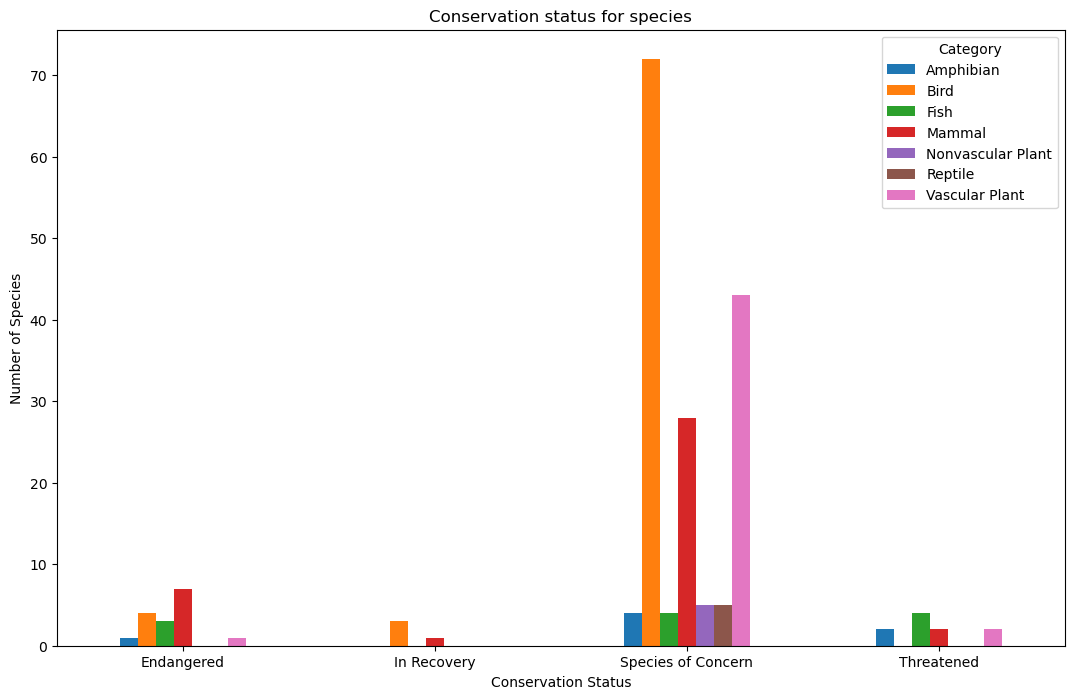

In [25]:
#A bar chart showing the number of Conservation status per category 
conservation_status_per_species.plot(kind='bar', stacked=False, figsize=[13, 8])
# Labels
plt.xlabel('Conservation Status')
plt.ylabel('Number of Species')
plt.grid(True, which='minor', linestyle='--', alpha=0.8)
plt.xticks(rotation=0)
plt.title('Conservation status for species')

plt.show()


Getting a full dataset for the analysis by performing an outer merge of the species dataset and the observations dataset

In [6]:
#merging species dataset and observation dataset
full_df = species_df.merge(observations_df, on = 'scientific_name', how='outer')
full_df.head()

,category,scientific_name,common_names,conservation_status,park_name,observations
0,Vascular Plant,Abies bifolia,Rocky Mountain Alpine Fir,NaN,Bryce National Park,109
1,Vascular Plant,Abies bifolia,Rocky Mountain Alpine Fir,NaN,Yellowstone National Park,215
2,Vascular Plant,Abies bifolia,Rocky Mountain Alpine Fir,NaN,Great Smoky Mountains National Park,72
3,Vascular Plant,Abies bifolia,Rocky Mountain Alpine Fir,NaN,Yosemite National Park,136
4,Vascular Plant,Abies concolor,"Balsam Fir, Colorado Fir, Concolor Fir, Silver...",NaN,Great Smoky Mountains National Park,101


In [7]:
#checking the numbers of rows and columns for the full dataset
print(full_df.shape)

(25632, 6)


In [8]:
print(f"number of parks:{full_df.park_name.nunique()}")
print(f"unique parks:{full_df.park_name.unique()}")

number of parks:4
unique parks:['Bryce National Park' 'Yellowstone National Park'
 'Great Smoky Mountains National Park' 'Yosemite National Park']


            category  observations
0     Vascular Plant       2795312
1               Bird        332371
2  Nonvascular Plant        190653
3             Mammal        163120
4               Fish         72901
5            Reptile         45822
6          Amphibian         45068


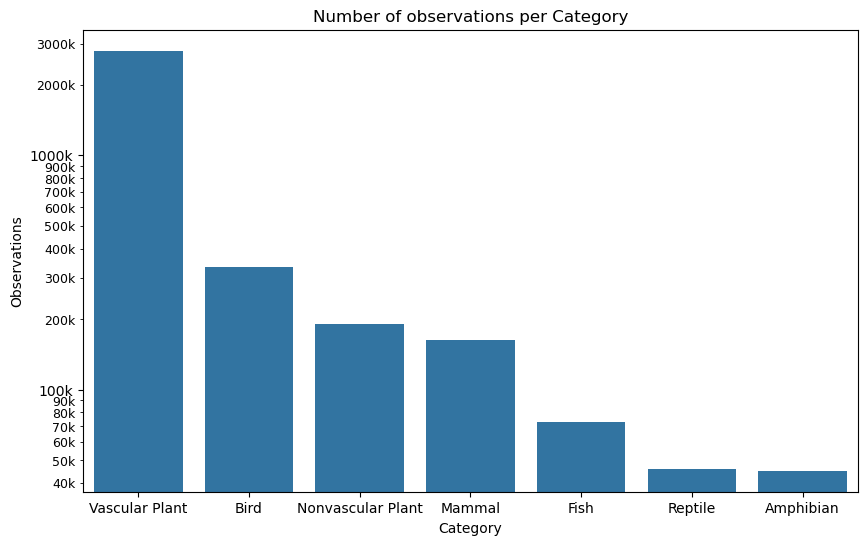

In [72]:
#A bar chart showing the number of observations per category
#create a dataframe with observations and category
cat_obs_df = full_df[["category", "observations"]].groupby("category").sum().sort_values("observations", ascending=False).reset_index()
print(cat_obs_df)
#Bar plot
plt.figure(figsize=[10,6])
sns.barplot(x=cat_obs_df.category, y=cat_obs_df.observations)
plt.xlabel("Category")
plt.ylabel("Observations")
plt.title("Number of observations per Category")
plt.yscale("log")
plt.gca().yaxis.set_major_formatter(lambda x, pos: '0' if x==0 else '{:.0f}k'.format(x * 1e-3))
plt.gca().yaxis.set_minor_formatter(lambda x, pos: '0' if x==0 else '{:.0f}k'.format(x * 1e-3))
plt.tick_params(which='minor', labelsize = 9)
plt.show()

Which species were spotted the most at the park?

MOST SPOTTED SPECIES AT EACH PARK

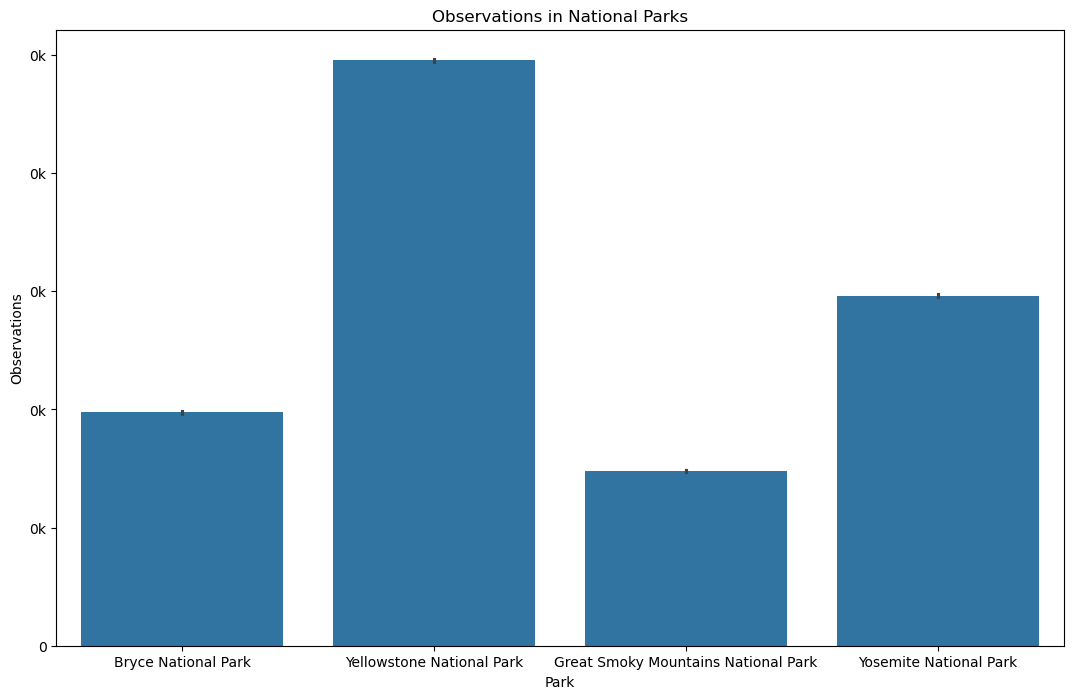

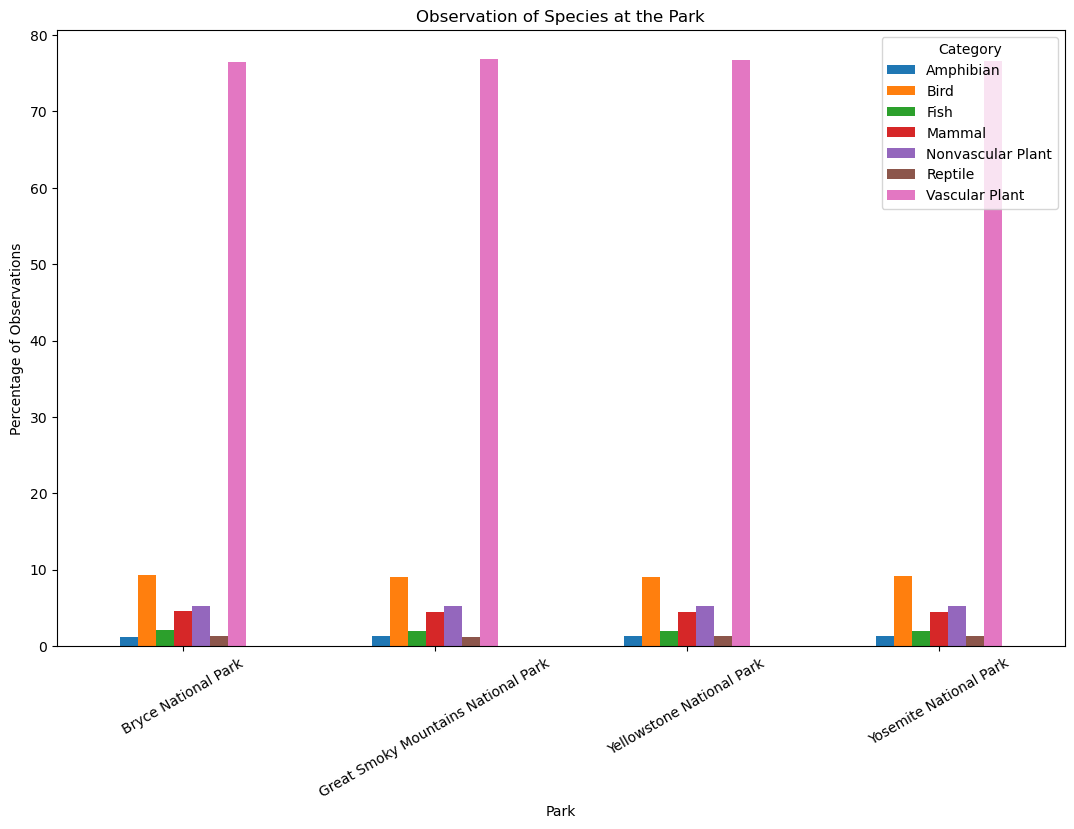

Category,Amphibian,Bird,Fish,Mammal,Nonvascular Plant,Reptile,Vascular Plant
Park name,,,,,,,
Bryce National Park,1.2%,9.3%,2.0%,4.6%,5.2%,1.3%,76.5%
Great Smoky Mountains National Park,1.2%,9.0%,2.0%,4.4%,5.2%,1.2%,76.8%
Yellowstone National Park,1.3%,9.1%,2.0%,4.5%,5.2%,1.3%,76.7%
Yosemite National Park,1.2%,9.1%,2.0%,4.5%,5.2%,1.2%,76.7%


In [46]:
# Creating a dataframe with parks and observations
park_observe_df = full_df.pivot_table(index='park_name', columns='category', values='observations', aggfunc='sum')
# Converting the values to percentage
park_observe_df = park_observe_df.apply(lambda x: x/x.sum()*100, axis=1)

park_observe_df.rename_axis('Park name', inplace=True)
park_observe_df.rename_axis('Category', axis='columns', inplace=True)

# Bar plot
plt.figure(figsize=[13, 8])
sns.barplot(data=full_df, x='park_name', y='observations')
plt.xlabel('Park')
plt.ylabel('Observations')
plt.gca().yaxis.set_major_formatter(lambda x, pos: '0' if x==0 else '{:.0f}k'.format(x * 1e-3))
plt.gca().yaxis.set_minor_formatter(lambda x, pos: '0' if x==0 else '{:.0f}k'.format(x * 1e-3))

plt.title('Observations in National Parks')

plt.show()

# Bar plot percentages
park_observe_df.plot(kind='bar', stacked=False, figsize=[13, 8])
# Labels
plt.xlabel('Park')
plt.ylabel('Percentage of Observations')
plt.xticks(rotation=30)
plt.title('Observation of Species at the Park')

plt.show()

# Add table
display(park_observe_df.style
        .format("{:.1f}%")
        .set_caption('Observation percentages'))

In [9]:

#replacing any nan values in conservation_status with "No status"
full_df.fillna('No Status', inplace=True)
full_df.groupby("conservation_status").size()
full_df.head()

,category,scientific_name,common_names,conservation_status,park_name,observations
0,Vascular Plant,Abies bifolia,Rocky Mountain Alpine Fir,No Status,Bryce National Park,109
1,Vascular Plant,Abies bifolia,Rocky Mountain Alpine Fir,No Status,Yellowstone National Park,215
2,Vascular Plant,Abies bifolia,Rocky Mountain Alpine Fir,No Status,Great Smoky Mountains National Park,72
3,Vascular Plant,Abies bifolia,Rocky Mountain Alpine Fir,No Status,Yosemite National Park,136
4,Vascular Plant,Abies concolor,"Balsam Fir, Colorado Fir, Concolor Fir, Silver...",No Status,Great Smoky Mountains National Park,101


Are certain types of species that are most likely to be endangered?

ENDANGERED SPECIES

In [37]:

#Checking the types of species that are most likely to be endangered
full_df['endangered'] = full_df.conservation_status == 'Endangered'

full_df.head()

,category,scientific_name,common_names,conservation_status,park_name,observations,endangered
0,Vascular Plant,Abies bifolia,Rocky Mountain Alpine Fir,No Status,Bryce National Park,109,False
1,Vascular Plant,Abies bifolia,Rocky Mountain Alpine Fir,No Status,Yellowstone National Park,215,False
2,Vascular Plant,Abies bifolia,Rocky Mountain Alpine Fir,No Status,Great Smoky Mountains National Park,72,False
3,Vascular Plant,Abies bifolia,Rocky Mountain Alpine Fir,No Status,Yosemite National Park,136,False
4,Vascular Plant,Abies concolor,"Balsam Fir, Colorado Fir, Concolor Fir, Silver...",No Status,Great Smoky Mountains National Park,101,False


In [38]:
#sum of endangered species and non_endangered species
full_df.groupby('endangered').size()

endangered
False    25552
True        80
dtype: int64

In [39]:
#dataset containing values of species that are endagered
endangered_species = full_df[full_df["endangered"] == True]
endangered_species.head()

,category,scientific_name,common_names,conservation_status,park_name,observations,endangered
3624,Mammal,Canis lupus,Gray Wolf,Endangered,Yosemite National Park,35,True
3625,Mammal,Canis lupus,Gray Wolf,Endangered,Bryce National Park,27,True
3626,Mammal,Canis lupus,Gray Wolf,Endangered,Bryce National Park,29,True
3627,Mammal,Canis lupus,Gray Wolf,Endangered,Bryce National Park,74,True
3628,Mammal,Canis lupus,Gray Wolf,Endangered,Great Smoky Mountains National Park,15,True


In [40]:
#sum of endangered species
endangered_species.groupby('endangered').size()

endangered
True    80
dtype: int64

In [41]:
#dataset for endangered species and category
endangered_species_df = endangered_species.groupby(["endangered", "category"]).agg({'observations':'count'})
endangered_species_df = endangered_species_df.rename(columns = {'observations': 'species_count'})
endangered_species_df = endangered_species_df.reset_index()
endangered_species_df

,endangered,category,species_count
0,True,Amphibian,4
1,True,Bird,16
2,True,Fish,12
3,True,Mammal,44
4,True,Vascular Plant,4


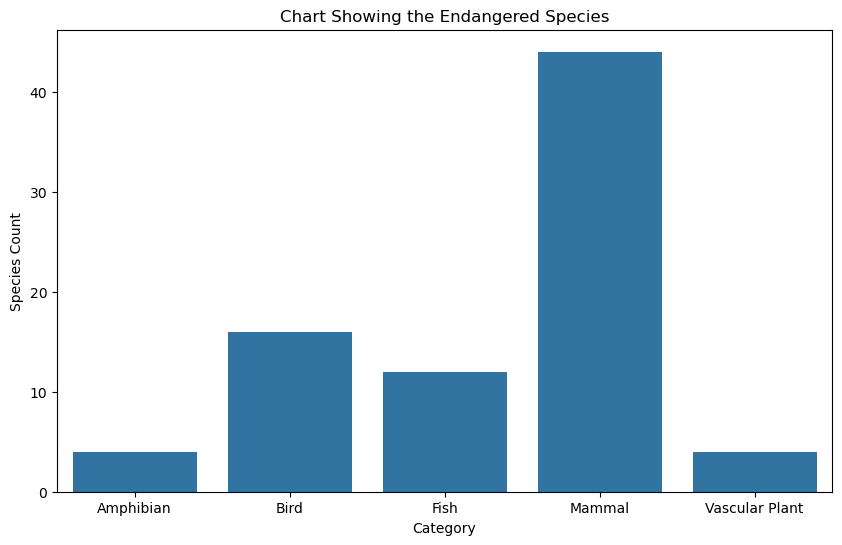

In [45]:

#A bar chart showing the species that is more likely to be endangered
#Bar plot
plt.figure(figsize=[10,6])
sns.barplot(x=endangered_species_df.category, y=endangered_species_df.species_count)
plt.xlabel("Category")
plt.ylabel("Species Count")
plt.title('Chart Showing the Endangered Species')
plt.tick_params(which='minor', labelsize = 9)
plt.show()


From our chart of endangered species, Mammal has the highest count of species. Now let's see each park with different rate of endangered_species vs. non_endangered species of Mammals sighting. 

In [57]:
#updating the full dataset with a column where category is equal to mammal
full_df['is_mammal'] = full_df.category == 'Mammal'
full_df.head()

,category,scientific_name,common_names,conservation_status,park_name,observations,endangered,is_mammal
0,Vascular Plant,Abies bifolia,Rocky Mountain Alpine Fir,No Status,Bryce National Park,109,False,False
1,Vascular Plant,Abies bifolia,Rocky Mountain Alpine Fir,No Status,Yellowstone National Park,215,False,False
2,Vascular Plant,Abies bifolia,Rocky Mountain Alpine Fir,No Status,Great Smoky Mountains National Park,72,False,False
3,Vascular Plant,Abies bifolia,Rocky Mountain Alpine Fir,No Status,Yosemite National Park,136,False,False
4,Vascular Plant,Abies concolor,"Balsam Fir, Colorado Fir, Concolor Fir, Silver...",No Status,Great Smoky Mountains National Park,101,False,False


In [110]:
#creat a column where the value of is_mammal column equals true
mammal_observations = full_df[full_df.is_mammal]
mammal_observations

,category,scientific_name,common_names,conservation_status,park_name,observations,endangered,is_mammal,is_bat
588,Mammal,Alces alces,"Eurasian Elk, Moose",No Status,Yosemite National Park,161,False,True,False
589,Mammal,Alces alces,"Eurasian Elk, Moose",No Status,Yellowstone National Park,197,False,True,False
590,Mammal,Alces alces,"Eurasian Elk, Moose",No Status,Bryce National Park,101,False,True,False
591,Mammal,Alces alces,"Eurasian Elk, Moose",No Status,Great Smoky Mountains National Park,44,False,True,False
592,Mammal,Alces alces shirasi,Yellowstone Moose,No Status,Great Smoky Mountains National Park,83,False,True,False
...,...,...,...,...,...,...,...,...,...
25547,Mammal,Zapus hudsonius,Meadow Jumping Mouse,No Status,Bryce National Park,84,False,True,False
25548,Mammal,Zapus princeps,Western Jumping Mouse,No Status,Great Smoky Mountains National Park,76,False,True,False
25549,Mammal,Zapus princeps,Western Jumping Mouse,No Status,Yosemite National Park,138,False,True,False
25550,Mammal,Zapus princeps,Western Jumping Mouse,No Status,Yellowstone National Park,235,False,True,False


Which animal is most Prevalant and what is their distribution amongst parks

MOST PREVALENT ANIMAL AND DISTRIBUTION

In [102]:

# Create a bag of words with all words from animals' common_names
words_counted = (
   mammal_observations.common_names
        .dropna()  # avoid errors from NaN
        .str.replace(',', '', regex=False)
        .str.split()   # split on whitespace
)
word_count = (
    pd.Series([word for words in words_counted.values for word in words], name='word')
      .value_counts().to_frame('count'))

word_count.head(20)

,count
word,
Bat,228
Shrew,168
Myotis,164
Brown,100
American,96
Mouse,76
Gray,76
Raccoon,72
Western,72


From the above analysis, it seems that Bat occurred 228 times while Shrew came up 168 times. So Bat is the most prevalent animal which happens to be under the mammal category.

In [103]:
#checking for common names that contain the word Bat
full_df['is_bat'] =  full_df.common_names.astype(str).str.contains(r"\bBat\b", regex = True, case=False, na = False)

 full_df.head(10)

,category,scientific_name,common_names,conservation_status,park_name,observations,endangered,is_mammal,is_bat
0,Vascular Plant,Abies bifolia,Rocky Mountain Alpine Fir,No Status,Bryce National Park,109,False,False,False
1,Vascular Plant,Abies bifolia,Rocky Mountain Alpine Fir,No Status,Yellowstone National Park,215,False,False,False
2,Vascular Plant,Abies bifolia,Rocky Mountain Alpine Fir,No Status,Great Smoky Mountains National Park,72,False,False,False
3,Vascular Plant,Abies bifolia,Rocky Mountain Alpine Fir,No Status,Yosemite National Park,136,False,False,False
4,Vascular Plant,Abies concolor,"Balsam Fir, Colorado Fir, Concolor Fir, Silver...",No Status,Great Smoky Mountains National Park,101,False,False,False
5,Vascular Plant,Abies concolor,"Balsam Fir, Colorado Fir, Concolor Fir, Silver...",No Status,Bryce National Park,83,False,False,False
6,Vascular Plant,Abies concolor,"Balsam Fir, Colorado Fir, Concolor Fir, Silver...",No Status,Yellowstone National Park,241,False,False,False
7,Vascular Plant,Abies concolor,"Balsam Fir, Colorado Fir, Concolor Fir, Silver...",No Status,Yosemite National Park,205,False,False,False
8,Vascular Plant,Abies fraseri,Fraser Fir,Species of Concern,Bryce National Park,109,False,False,False
9,Vascular Plant,Abies fraseri,Fraser Fir,Species of Concern,Great Smoky Mountains National Park,81,False,False,False


In [106]:
#filtering the dataset to only values where common_names equals Bat
is_bat_observations = full_df[full_df.is_bat]
is_bat_observations

,category,scientific_name,common_names,conservation_status,park_name,observations,endangered,is_mammal,is_bat
1384,Mammal,Antrozous pallidus,"Pallid Bat, Pallid Bat",Species of Concern,Great Smoky Mountains National Park,61,False,True,True
1385,Mammal,Antrozous pallidus,"Pallid Bat, Pallid Bat",Species of Concern,Yosemite National Park,134,False,True,True
1386,Mammal,Antrozous pallidus,"Pallid Bat, Pallid Bat",Species of Concern,Yellowstone National Park,244,False,True,True
1387,Mammal,Antrozous pallidus,"Pallid Bat, Pallid Bat",Species of Concern,Bryce National Park,67,False,True,True
6472,Mammal,Corynorhinus rafinesquii,Rafinesque's Big-Eared Bat,No Status,Yosemite National Park,188,False,True,True
...,...,...,...,...,...,...,...,...,...
16403,Mammal,Parastrellus hesperus,Canyon Bat,No Status,Yellowstone National Park,255,False,True,True
23376,Mammal,Tadarida brasiliensis,Mexican Free-Tailed Bat,No Status,Yosemite National Park,177,False,True,True
23377,Mammal,Tadarida brasiliensis,Mexican Free-Tailed Bat,No Status,Yellowstone National Park,251,False,True,True
23378,Mammal,Tadarida brasiliensis,Mexican Free-Tailed Bat,No Status,Great Smoky Mountains National Park,71,False,True,True


In [107]:
#creating a dataframe for count of endangered Bat species in all four parks and also non_endangered bat
bat_obs_by_park = is_bat_observations.groupby(['park_name', 'endangered']).observations.sum().reset_index()
bat_obs_by_park

,park_name,endangered,observations
0,Bryce National Park,False,3406
1,Bryce National Park,True,27
2,Great Smoky Mountains National Park,False,2397
3,Great Smoky Mountains National Park,True,14
4,Yellowstone National Park,False,8294
5,Yellowstone National Park,True,68
6,Yosemite National Park,False,4750
7,Yosemite National Park,True,36


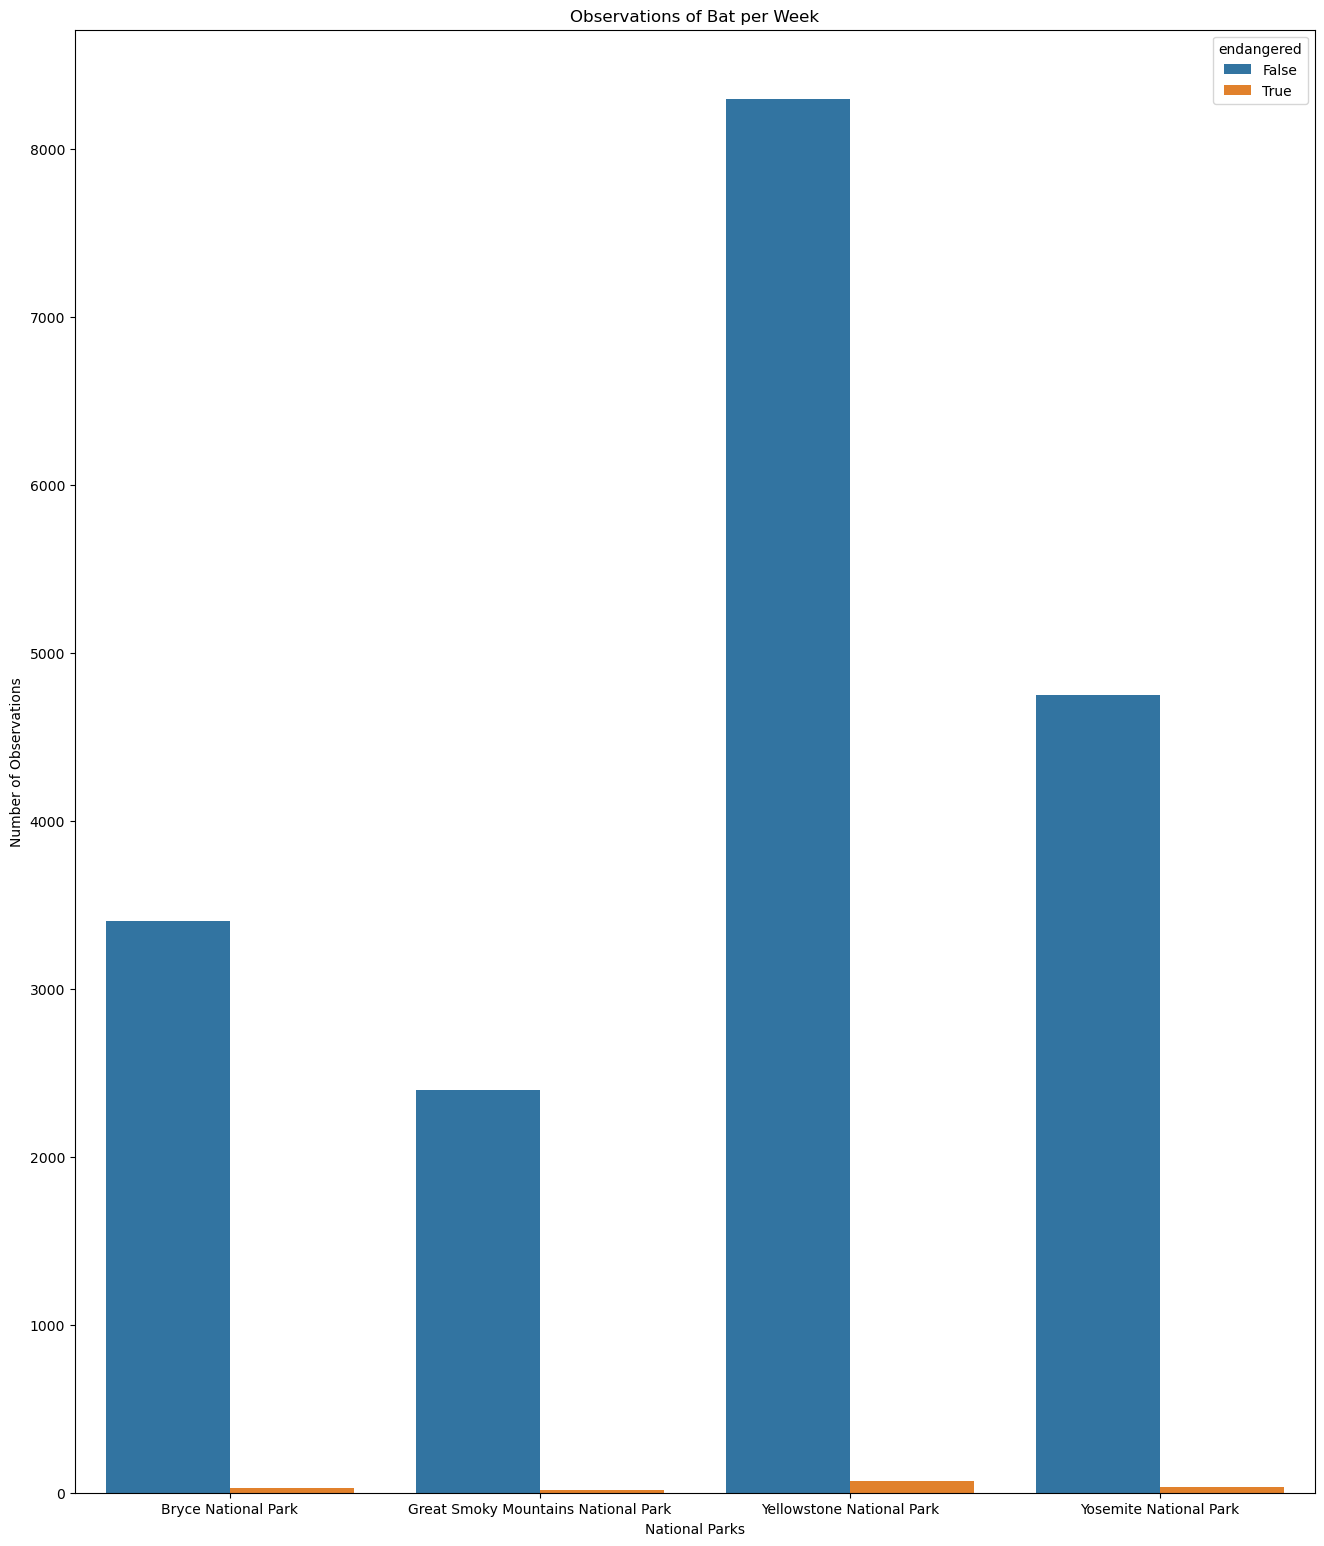

In [108]:
#Bar chart showing the count of endangered Bat species in all four parks and comparing it to other animals in the park
plt.figure(figsize=(16, 19))
sns.barplot(x=bat_obs_by_park.park_name, y= bat_obs_by_park.observations, hue=bat_obs_by_park.endangered)
plt.xlabel('National Parks')
plt.ylabel('Number of Observations')
plt.title('Observations of Bat per Week')
plt.show()

Are the difference between species and their conservation status significant?

STATISTICAL SIGNIFICANCE


This section will run some chi-squared tests to see if different species have statistically significant differences in conservation status rates. In order to run a chi squared test, a contingency table will need to be created.

In [35]:
# The first test will be for Mammal and Bird. We will check for a statistically significant difference between both species category and their conservation status
mammal_bird = full_df[(full_df.category.str.contains('Mammal|Bird'))].copy()
mammal_bird  = mammal_bird [['park_name','category','conservation_status']].reset_index(drop=True)
# Add an Mammal or Bird identifier
mammal_bird['Mammal_or_Bird'] = mammal_bird.category.apply(lambda x: 'Mammal' if 'Mammal' in x else 'Bird') 
mammal_bird.head()

,park_name,category,conservation_status,Mammal_or_Bird
0,Great Smoky Mountains National Park,Bird,No Status,Bird
1,Bryce National Park,Bird,No Status,Bird
2,Yosemite National Park,Bird,No Status,Bird
3,Yellowstone National Park,Bird,No Status,Bird
4,Bryce National Park,Bird,Species of Concern,Bird


In [31]:

# Create a contingency table
contingency_mammal_bird = pd.crosstab(mammal_bird.conservation_status, mammal_bird.Mammal_or_Bird)
# Adjust row/column description
contingency_mammal_bird.rename_axis('Conservation Status', inplace=True)
contingency_mammal_bird.rename_axis('Mammal/Bird', axis='columns', inplace=True)
display(contingency_mammal_bird.style.set_caption('Contingency table'))

# Run chi2 test
chi2, pval, _, expected_f = chi2_contingency(contingency_mammal_bird)
alfa = 0.05
result = ('significant' if pval < alfa else 'not significant')

print(f'chi2: {chi2:.2f}')
print(f'p-value: {pval:.3e}')
print(f'Test result: association between Mammal and Bird species is {result} (alfa = {alfa})')

Mammal/Bird,Bird,Mammal
Conservation Status,,
Endangered,16,44
In Recovery,12,12
No Status,2016,968
Species of Concern,320,168
Threatened,0,8


chi2: 63.04
p-value: 6.663e-13
Test result: association between Mammal and Bird species is significant (alfa = 0.05)


In [25]:
# The second test will be for Mammal and fish. We will check for a statistically significant difference between both species category and their conservation status
mammal_fish = full_df[(full_df.category.str.contains('Mammal|Fish'))].copy()
mammal_fish  = mammal_fish [['park_name','category','conservation_status']].reset_index(drop=True)
# Add an Mammal or Fish identifier
mammal_fish['Mammal_or_Fish'] = mammal_fish.category.apply(lambda x: 'Mammal' if 'Mammal' in x else 'Fish') 
mammal_fish.head()

,park_name,category,conservation_status,Mammal_or_Fish
0,Yosemite National Park,Mammal,No Status,Mammal
1,Yellowstone National Park,Mammal,No Status,Mammal
2,Bryce National Park,Mammal,No Status,Mammal
3,Great Smoky Mountains National Park,Mammal,No Status,Mammal
4,Great Smoky Mountains National Park,Mammal,No Status,Mammal


In [32]:
# Create a contingency table
contingency_mammal_fish = pd.crosstab(mammal_fish.conservation_status, mammal_fish.Mammal_or_Fish)
# Adjust row/column description
contingency_mammal_fish.rename_axis('Conservation Status', inplace=True)
contingency_mammal_fish.rename_axis('Mammal/Fish', axis='columns', inplace=True)
display(contingency_mammal_fish.style.set_caption('Contingency table'))

# Run chi2 test
chi2, pval, _, expected_f = chi2_contingency(contingency_mammal_fish)
alfa = 0.05
result = ('significant' if pval < alfa else 'not significant')

print(f'chi2: {chi2:.2f}')
print(f'p-value: {pval:.3e}')
print(f'Test result: association between Mammal and Fish species is {result} (alfa = {alfa})')

Mammal/Fish,Fish,Mammal
Conservation Status,,
Endangered,12,44
In Recovery,0,12
No Status,476,968
Species of Concern,16,168
Threatened,20,8


chi2: 75.11
p-value: 1.890e-15
Test result: association between Mammal and Fish species is significant (alfa = 0.05)


In [27]:
# The third test will be for Fish and Bird. We will check for a statistically significant difference between both species category and their conservation status
fish_bird = full_df[(full_df.category.str.contains('Fish|Bird'))].copy()
fish_bird  = fish_bird [['park_name','category','conservation_status']].reset_index(drop=True)
# Add an Fish or Bird identifier
fish_bird['Fish_or_Bird'] = fish_bird.category.apply(lambda x: 'Fish' if 'Fish' in x else 'Bird') 
fish_bird.head()

,park_name,category,conservation_status,Fish_or_Bird
0,Great Smoky Mountains National Park,Bird,No Status,Bird
1,Bryce National Park,Bird,No Status,Bird
2,Yosemite National Park,Bird,No Status,Bird
3,Yellowstone National Park,Bird,No Status,Bird
4,Bryce National Park,Bird,Species of Concern,Bird


In [109]:
# Create a contingency table
contingency_fish_bird = pd.crosstab(fish_bird.conservation_status, fish_bird.Fish_or_Bird)
# Adjust row/column description
contingency_fish_bird.rename_axis('Conservation Status', inplace=True)
contingency_fish_bird.rename_axis('Fish/Bird', axis='columns', inplace=True)
display(contingency_fish_bird.style.set_caption('Contingency table'))

# Run chi2 test
chi2, pval, _, expected_f = chi2_contingency(contingency_fish_bird)
alfa = 0.05
result = ('significant' if pval < alfa else 'not significant')

print(f'chi2: {chi2:.2f}')
print(f'p-value: {pval:.3e}')
print(f'Test result: association between Fish and Bird species is {result} (alfa = {alfa})')

Fish/Bird,Bird,Fish
Conservation Status,,
Endangered,16,12
In Recovery,12,0
No Status,2016,476
Species of Concern,320,16
Threatened,0,20


chi2: 146.45
p-value: 1.171e-30
Test result: association between Fish and Bird species is significant (alfa = 0.05)


CONCLUSION AND RESULTS
The project was able to make several data analysis and visualizations about the various species in four of the National Parks. I was also able to answer some of the questions posed in the goals of the project:
1) What is the distribution of conservation status for species?

Total species rows: 5,824.

Conservation status counts:
No Status: 5,633 species (96.72%)
Species of Concern: 161 species (2.76%)
Endangered: 16 species (0.27%)
Threatened: 10 species (0.17%)
In Recovery: 4 species (0.07%)

A bar chart of this distribution was generated.

Interpretation: The vast majority of species entries have no conservation status recorded in this dataset. This large missingness strongly affects any downstream inference about the frequency of statuses.

2) Are certain types of species more likely to be endangered?

Proportions of Endangered by category were computed where applicable.
Top proportions (if Endangered exists):
e.g., Mammal and Birds had the highest endangered entries.

3) Are the differences between species and their conservation status significant?

I created a contingency table (species category × conservation_status_filled) ran a Chi-square test of independence on the contingency table:
Test result: chi2 and p_value were computed.
While mammals and Birds gave significant difference in conservation percentage, mammals and fish exhibited a statistically significant difference as well as fish and bird.

4) Which animal is most prevalent and what is their distribution amongst parks?

Most observed species (common name): I extracted the top species name from the observations dataset.
I created a bar chart showing that species' observations across parks (top parks displayed). The study found that bats occurred the most number of times and they were most likely to be found in Yellowstone National Park.

5) Species spotted the most at each park?
For each park, I found the species with the maximum total observations and saved the result as park_top_species.csv.

FURTHER RESEARCH AND RECOMMENDATION

Massive missingness in conservation_status (96.7% Not Listed).
This will bias conclusions. I recommend enriching the dataset with authoritative conservation status sources (IUCN Red List, national lists) for missing species to have robust results.

Species name matching: I used scientific_name as the join key. If names have synonyms or spelling variants, consider taxonomic name resolution (e.g., GBIF backbone) for more accurate merges.

Re-run the association test excluding 'No status' and present adjusted results.

Time-trend analyses if you have temporal data:
This dataset only included observations from the last 7 days which prohibits analyze changes over time. It is recommended to see how the conservation status for various species changes over time. 

Another piece is Area of each park. Maps of species hotspots if park coordinates are available, it can be assumed that Yellowstone National Park might be much larger than the other parks which would mean that it would exhibit more observations and greater biodiversity. 
